In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
device = 'cuda'
from time import time

import losses
from utils import ScatteringProblemForward
from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes

In [48]:
filename_out    = 'output/ff_nn.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1.0e-4
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 500

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_x_features     = 7

ndim_y     = 512

# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None


############
#  Losses  #
############

train_forward_mmd    = True

lambd_mmd_for_class    = 10
lambd_mmd_for_feature  = 100

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 0 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 25
#
exponent_clamping = 2.0
#
hidden_layer_sizes = 1024
#
use_permutation = True
#
verbose_construction = False

In [3]:
lp = ScatteringProblemForward( device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, 
                        lambd_mmd_for_class, lambd_mmd_for_feature, mmd_back_weighted, y_uncertainty_sigma, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [4]:
lp.read_data('/home/slaskina/simulations')
lp.normalize_inputs()

In [49]:
lp.update_hyperparameters( device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, 
                        lambd_mmd_for_class, lambd_mmd_for_feature, mmd_back_weighted, y_uncertainty_sigma, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [50]:
lp.create_loaders()

In [51]:
class ForwardScatteringResNet(nn.Module):
    def __init__(self, N_blocks, ResNet_block) -> None:
        super().__init__()
        self.N_blocks = N_blocks
        self.resnet_blocks = ResNet_block
        self.res_block = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size = 5,padding = 2, stride=1),
            nn.ELU(),
            nn.AvgPool1d(5, padding=2, stride=1),
        )
        self.s1 = nn.Sequential(
            nn.Conv1d(in_channels = 512, out_channels = 128 , kernel_size = 11, padding=5, stride=3),
            nn.ELU()
        )
        self.linear_out = nn.Sequential(    
            nn.Linear(128, 10),
            nn.ELU()
        )
        self.activation = nn.ELU()
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = x.reshape(len(x), -1, 1)
        for _ in range(self.N_blocks):
            residual = x
            for _ in range(self.resnet_blocks):
                x =  self.res_block(x)
            x += residual
            x = self.activation(x)

        x = self.s1(x)
        x = self.flatten(x)
        x = self.linear_out(x)
        return x.reshape(-1,10)
resnet_model = ForwardScatteringResNet(4,3)

In [52]:
lp.set_model(resnet_model)
lp.set_optimizer()

In [53]:
lp.train()

Epoch 0: training loss: 99.75588551963249, test loss: 45.09583746868631
Epoch 1: training loss: 42.05233150575219, test loss: 34.213938920394234
Epoch 2: training loss: 33.03393517470941, test loss: 29.65477586829144
Epoch 3: training loss: 28.80872119345316, test loss: 26.889013290405273
Epoch 4: training loss: 26.55699469403523, test loss: 25.523028498110563
Epoch 5: training loss: 25.29486684101384, test loss: 25.008307000865106
Epoch 6: training loss: 24.801010759865367, test loss: 24.096671394679856
Epoch 7: training loss: 24.43403313799602, test loss: 24.107132621433426
Epoch 8: training loss: 23.88521820161401, test loss: 23.744625091552734
Epoch 9: training loss: 23.842168319516066, test loss: 24.157099516495414
Epoch 10: training loss: 23.55904397731874, test loss: 23.55867576599121
Epoch 11: training loss: 23.267310514682677, test loss: 23.197590703549594
Epoch 12: training loss: 23.27869159419362, test loss: 23.127394220103387
Epoch 13: training loss: 23.17269488078792, test

In [54]:
df_train = lp.create_table_from_outcomes(lp.make_prediction(lp.train_indices), lp.train_indices)
df_val = lp.create_table_from_outcomes(lp.make_prediction(lp.val_indices), lp.val_indices) 
df_test = lp.create_table_from_outcomes(lp.make_prediction(lp.test_indices), lp.test_indices)

Accuracy is 99.78%
MSE for radius per shape for correctly identified instances as follows: sphere: 3459.6655, hardsphere: 1.1057 and cylinder: 524.5764
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 350.1493, hardsphere: 0.2596 and cylinder: 183.2894
MSE for cylinder length for correctly identified instances: 424.3173
MSE for cylinder length polydispersity for correctly identified instances: 22.5033
MSE for cylinder length for correctly identified instances: 0.3765


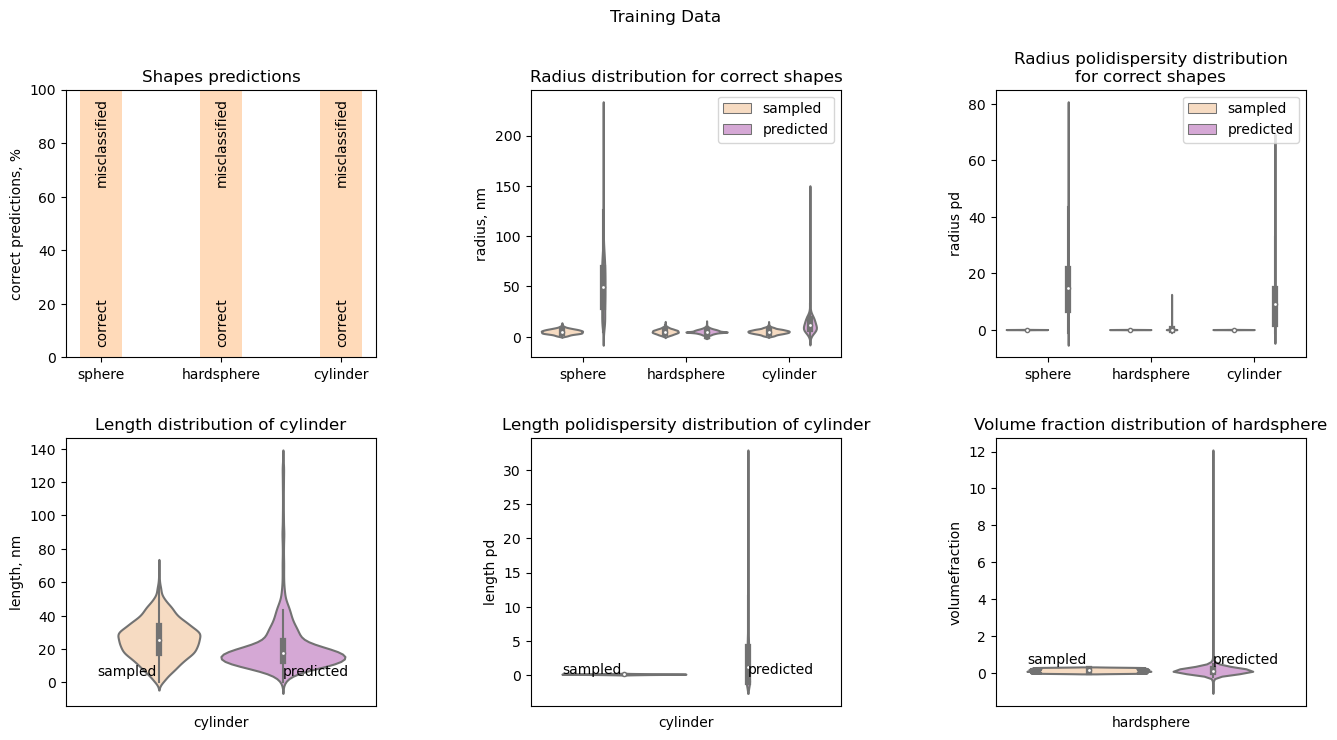

In [55]:
plot_outcomes_identified(df_train, 'Training')

Accuracy is 99.77%
MSE for radius per shape for correctly identified instances as follows: sphere: 3403.6223, hardsphere: 0.9364 and cylinder: 501.4120
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 337.3180, hardsphere: 0.0999 and cylinder: 166.7481
MSE for cylinder length for correctly identified instances: 399.9515
MSE for cylinder length polydispersity for correctly identified instances: 20.1476
MSE for cylinder length for correctly identified instances: 0.3654


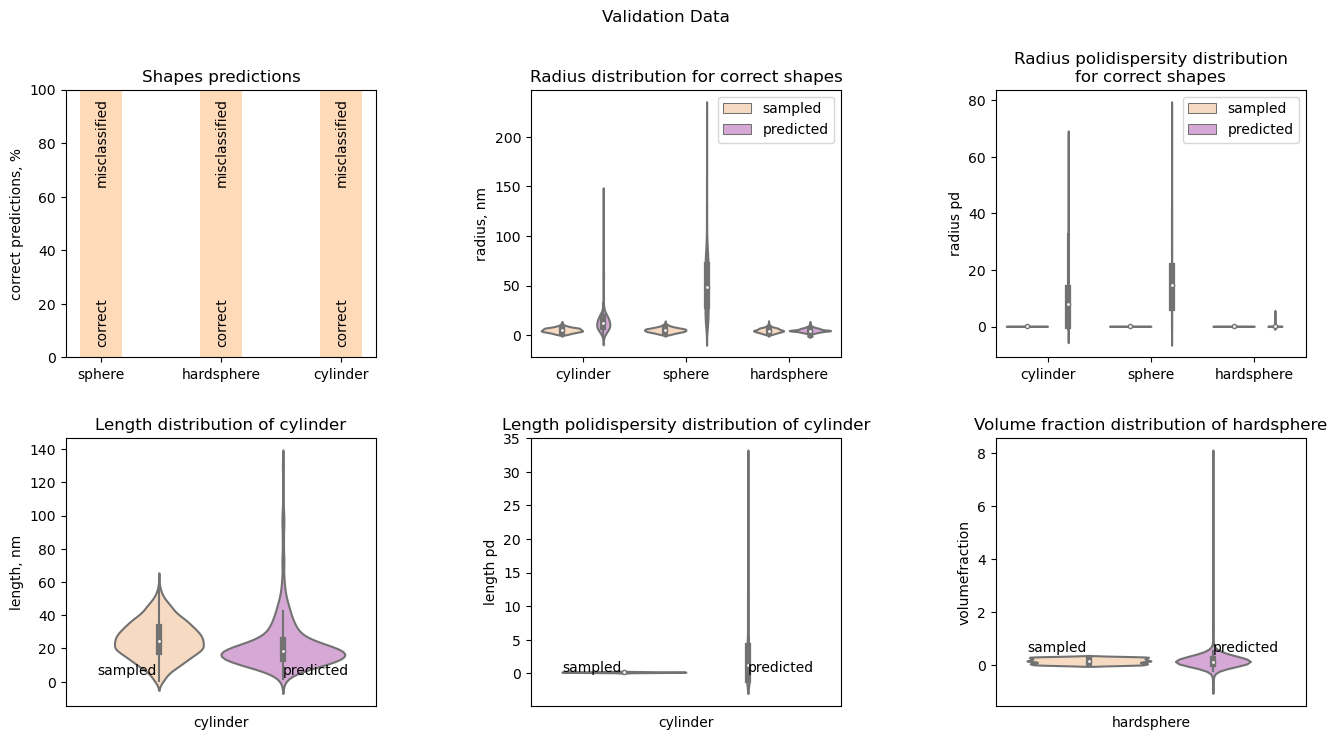

In [56]:
plot_outcomes_identified(df_val, 'Validation')

Accuracy is 99.73%
MSE for radius per shape for correctly identified instances as follows: sphere: 3144.0391, hardsphere: 1.1651 and cylinder: 315.8689
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 285.3327, hardsphere: 0.0791 and cylinder: 144.8862
MSE for cylinder length for correctly identified instances: 311.9008
MSE for cylinder length polydispersity for correctly identified instances: 15.0111
MSE for cylinder length for correctly identified instances: 0.5027


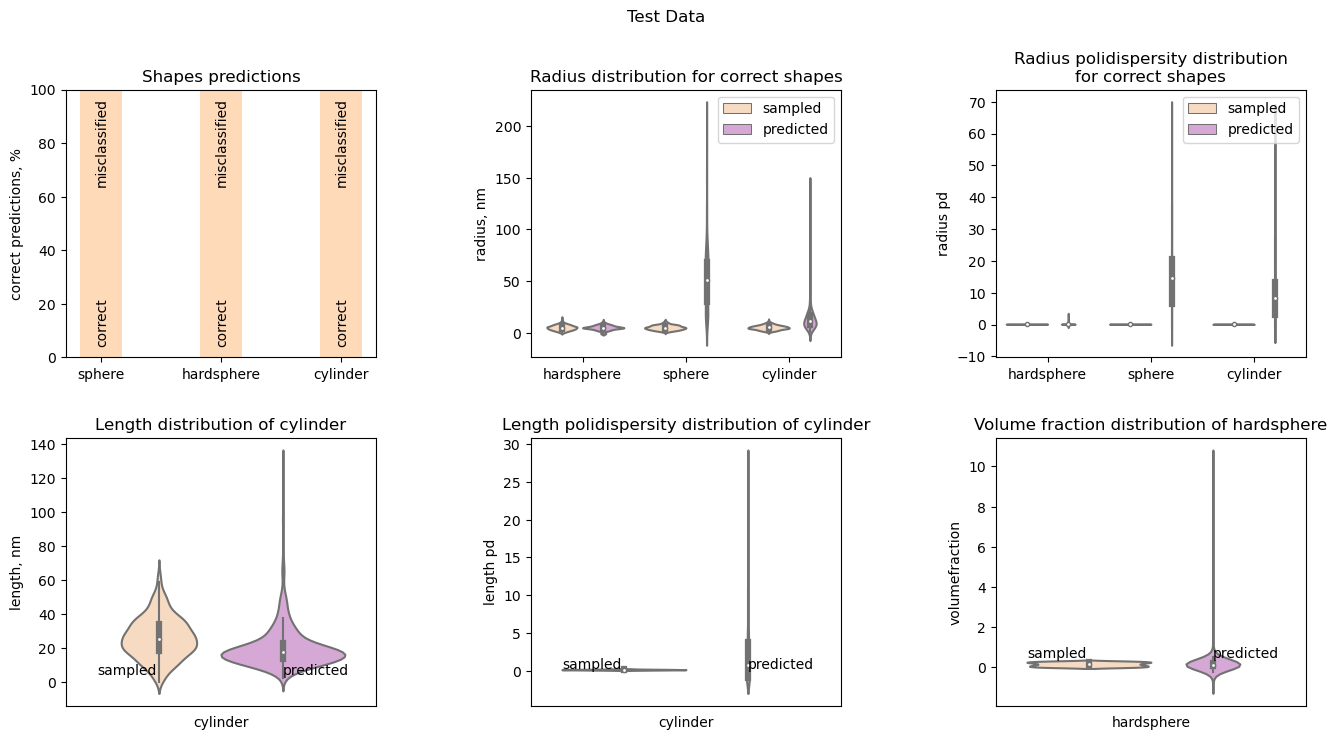

In [57]:
plot_outcomes_identified(df_test, 'Test')

In [58]:
df_test

,true_shape,pred_shape,radius,pred_radius,radius_pd,pred_radius_pd,length,pred_length,length_pd,pred_length_pd,volfraction,pred_volfraction
0,1,1,4.521623,4.543767,0.137957,0.164393,0.000000,0.006456,0.000000,0.034182,0.20,0.231479
1,2,2,7.016451,13.021780,0.110119,-0.503254,15.069812,16.930202,0.166154,1.861024,0.00,7.133937
2,2,2,6.242439,7.309320,0.104703,4.340444,23.140541,14.783432,0.257852,3.863144,0.00,13.224210
3,2,2,8.598413,10.591578,0.146229,0.815201,10.450610,17.173286,0.118462,1.358456,0.00,12.023631
4,1,1,5.372845,5.425596,0.139639,0.113815,0.000000,0.039011,0.000000,0.006578,0.05,0.052492
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1,1,0.215263,0.088737,0.103530,-0.142920,0.000000,0.061079,0.000000,-0.102661,0.30,0.040358
1496,0,0,7.928937,15.234181,0.070772,1.444737,0.000000,14.334456,0.000000,2.940097,0.00,6.441622
1497,2,2,2.721311,12.804340,0.158766,18.580732,34.106861,12.102436,0.126336,-0.966783,0.00,34.488289
1498,0,0,6.885484,11.141377,0.064197,15.720362,0.000000,3.609983,0.000000,5.445477,0.00,17.059618
